In [1]:

# IRT Fault Detection Using Transfer Learning with VGG-16

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import time

In [2]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70

In [3]:
# --- Organize Dataset ---
original_data_dir = '/Users/reamy/Desktop/THESIS/MC_dataset copy 2'  # Contains block and patchwork
base_dir = 'data/processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories
for split in ['train', 'val']:
    for cls in ['Block', 'PatchWork']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['Block', 'PatchWork']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

In [4]:
# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 68 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [5]:
# --- Get True Labels for Callback ---
val_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

# --- Load VGG16 base model (without top) ---
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# --- Add custom classification head ---
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
# --- Compile Model ---
model.compile(
    optimizer='adamW',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
model.summary()

# Save model summary to file
summary_file_path = os.path.join(os.getcwd(), 'vgg16_model_summary.txt')
with io.StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + '\n'))
    summary_text = buf.getvalue()

with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model summary saved to /Users/reamy/Desktop/THESIS/VGG-16_MC/vgg16_model_summary.txt


In [7]:
# --- Custom Callback to Track Metrics ---
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, val_labels):
        self.val_generator = val_generator
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_generator, val_labels)

In [8]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_VGG16_BC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [9]:
# start timer
start_time = time.time()
# --- Train the Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[metrics_callback,early_stop,checkpoint]
)
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4809 - auc: 0.4958 - loss: 0.7455 - precision: 0.4896 - recall: 0.3949  
Epoch 1: Precision=0.5000, Recall=1.0000, F1 Score=0.6667

Epoch 1: val_loss improved from inf to 0.70028, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4783 - auc: 0.4968 - loss: 0.7455 - precision: 0.4844 - recall: 0.4064 - val_accuracy: 0.5000 - val_auc: 0.6543 - val_loss: 0.7003 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5071 - auc: 0.4723 - loss: 0.7216 - precision: 0.3851 - recall: 0.5118            
Epoch 2: Precision=0.6667, Recall=0.2222, F1 Score=0.3333

Epoch 2: val_loss improved from 0.70028 to 0.68380, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.5384 - auc: 0.5236 - loss: 0.7022 - precision: 0.4412 - recall: 0.5676 - val_accuracy: 0.5556 - val_auc: 0.7963 - val_loss: 0.6838 - val_precision: 0.6667 - val_recall: 0.2222
Epoch 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5185 - auc: 0.4925 - loss: 0.7290 - precision: 0.5087 - recall: 0.4063  
Epoch 3: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 3: val_loss improved from 0.68380 to 0.67841, saving model to best_VGG16_BC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5139 - auc: 0.4911 - loss: 0.7316 - precision: 0.5065 - recall: 0.4150 - val_accuracy: 0.5000 - val_auc: 0.8642 - val_loss: 0.6784 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4711 - auc: 0.4705 - loss: 0.7493 - precision: 0.4333 - recall: 0.3268  
Epoch 4: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 4: val_loss improved from 0.67841 to 0.66965, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4636 - auc: 0.4631 - loss: 0.7547 - precision: 0.4321 - recall: 0.3333 - val_accuracy: 0.8889 - val_auc: 0.9259 - val_loss: 0.6697 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5885 - auc: 0.5459 - loss: 0.7350 - precision: 0.5375 - recall: 0.4821  
Epoch 5: Precision=0.5625, Recall=1.0000, F1 Score=0.7200

Epoch 5: val_loss improved from 0.66965 to 0.66531, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5737 - auc: 0.5278 - loss: 0.7427 - precision: 0.5371 - recall: 0.4719 - val_accuracy: 0.6111 - val_auc: 0.9753 - val_loss: 0.6653 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5479 - auc: 0.7163 - loss: 0.6692 - precision: 0.4615 - recall: 0.7810
Epoch 6: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 6: val_loss improved from 0.66531 to 0.65820, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.5580 - auc: 0.6856 - loss: 0.6785 - precision: 0.4899 - recall: 0.7549 - val_accuracy: 0.8333 - val_auc: 0.9877 - val_loss: 0.6582 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4951 - auc: 0.4942 - loss: 0.7411 - precision: 0.4929 - recall: 0.4507  
Epoch 7: Precision=0.5625, Recall=1.0000, F1 Score=0.7200

Epoch 7: val_loss improved from 0.65820 to 0.65528, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4926 - auc: 0.4960 - loss: 0.7387 - precision: 0.4904 - recall: 0.4410 - val_accuracy: 0.6111 - val_auc: 0.9877 - val_loss: 0.6553 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4896 - auc: 0.4265 - loss: 0.7486 - precision: 0.4992 - recall: 0.5766  
Epoch 8: Precision=0.5000, Recall=1.0000, F1 Score=0.6667

Epoch 8: val_loss did not improve from 0.65528
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4922 - auc: 0.4399 - loss: 0.7447 - precision: 0.4994 - recall: 0.5795 - val_accuracy: 0.5000 - val_auc: 0.9938 - val_loss: 0.6636 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5327 - auc: 0.6474 - loss: 0.6678 - precision: 0.5288 - recall: 0.8612
Epoch 9: Precision=0.5000, Recall=1.0000, F1 Score=0.6667

Epoch 9: val_loss did not improve from 0.65528
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.5282 - auc: 0.624

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.6156 - auc: 0.6126 - loss: 0.6717 - precision: 0.5883 - recall: 0.8562 - val_accuracy: 0.5556 - val_auc: 1.0000 - val_loss: 0.6411 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 12/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4597 - auc: 0.7066 - loss: 0.7072 - precision: 0.3745 - recall: 0.3922        
Epoch 12: Precision=0.5625, Recall=1.0000, F1 Score=0.7200

Epoch 12: val_loss improved from 0.64107 to 0.63641, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.4882 - auc: 0.6694 - loss: 0.7052 - precision: 0.4211 - recall: 0.4632 - val_accuracy: 0.6111 - val_auc: 1.0000 - val_loss: 0.6364 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 13/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4461 - auc: 0.4950 - loss: 0.6940 - precision: 0.3317 - recall: 0.3614        
Epoch 13: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 13: val_loss improved from 0.63641 to 0.62634, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.4816 - auc: 0.5250 - loss: 0.6896 - precision: 0.3946 - recall: 0.4255 - val_accuracy: 0.8889 - val_auc: 1.0000 - val_loss: 0.6263 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 14/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5312 - auc: 0.5802 - loss: 0.6845 - precision: 0.5159 - recall: 0.562
Epoch 14: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 14: val_loss improved from 0.62634 to 0.62099, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5234 - auc: 0.5711 - loss: 0.6875 - precision: 0.5119 - recall: 0.5469 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.6210 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 15/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6269 - auc: 0.6384 - loss: 0.6594 - precision: 0.6945 - recall: 0.5196
Epoch 15: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 15: val_loss improved from 0.62099 to 0.61705, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.6209 - auc: 0.6323 - loss: 0.6639 - precision: 0.6741 - recall: 0.5294 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.6170 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 16/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6033 - auc: 0.7641 - loss: 0.5985 - precision: 0.6619 - recall: 0.6032  
Epoch 16: Precision=0.6429, Recall=1.0000, F1 Score=0.7826

Epoch 16: val_loss did not improve from 0.61705
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5811 - auc: 0.7296 - loss: 0.6137 - precision: 0.6248 - recall: 0.5921 - val_accuracy: 0.7222 - val_auc: 1.0000 - val_loss: 0.6173 - val_precision: 0.6429 - val_recall: 1.0000
Epoch 17/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5294 - auc: 0.5153 - loss: 0.7023 - precision: 0.6667 - recall: 0.5464
Epoch 17: Precision=0.5294, Recall=1.0000, F1 Score=0.6923

Epoch 17: val_loss improved from 0.61705 to 0.61672, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.5441 - auc: 0.5472 - loss: 0.6913 - precision: 0.6429 - recall: 0.5863 - val_accuracy: 0.5556 - val_auc: 1.0000 - val_loss: 0.6167 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 18/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6075 - auc: 0.6930 - loss: 0.6493 - precision: 0.5095 - recall: 0.6314  
Epoch 18: Precision=0.5625, Recall=1.0000, F1 Score=0.7200

Epoch 18: val_loss improved from 0.61672 to 0.60885, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.6100 - auc: 0.6851 - loss: 0.6490 - precision: 0.5321 - recall: 0.6500 - val_accuracy: 0.6111 - val_auc: 1.0000 - val_loss: 0.6089 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 19/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6763 - auc: 0.6502 - loss: 0.6524 - precision: 0.6492 - recall: 0.8220  
Epoch 19: Precision=0.6923, Recall=1.0000, F1 Score=0.8182

Epoch 19: val_loss improved from 0.60885 to 0.60144, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6837 - auc: 0.6641 - loss: 0.6490 - precision: 0.6517 - recall: 0.8297 - val_accuracy: 0.7778 - val_auc: 1.0000 - val_loss: 0.6014 - val_precision: 0.6923 - val_recall: 1.0000
Epoch 20/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6928 - auc: 0.5129 - loss: 0.5837 - precision: 0.4568 - recall: 0.3824            
Epoch 20: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 20: val_loss improved from 0.60144 to 0.58798, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.6850 - auc: 0.5751 - loss: 0.5892 - precision: 0.5185 - recall: 0.4265 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5880 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 21/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6936 - auc: 0.7323 - loss: 0.6300 - precision: 0.7509 - recall: 0.600
Epoch 21: Precision=1.0000, Recall=0.8889, F1 Score=0.9412

Epoch 21: val_loss improved from 0.58798 to 0.58469, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.6967 - auc: 0.7334 - loss: 0.6294 - precision: 0.7555 - recall: 0.5974 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.5847 - val_precision: 1.0000 - val_recall: 0.8889
Epoch 22/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5289 - auc: 0.6321 - loss: 0.6732 - precision: 0.5370 - recall: 0.2708  
Epoch 22: Precision=1.0000, Recall=0.3333, F1 Score=0.5000

Epoch 22: val_loss did not improve from 0.58469
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5217 - auc: 0.6205 - loss: 0.6802 - precision: 0.5278 - recall: 0.2546 - val_accuracy: 0.6667 - val_auc: 1.0000 - val_loss: 0.5893 - val_precision: 1.0000 - val_recall: 0.3333
Epoch 23/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6284 - auc: 0.7580 - loss: 0.6030 - precision: 0.7222 - recall: 0.245
Epoch 23: Precision=1.0000, Recall=0.4444, F1 Score=0.6154

Epoch 23: val_loss improved from 0.58469 to 0.58182, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6183 - auc: 0.7517 - loss: 0.6120 - precision: 0.7292 - recall: 0.2504 - val_accuracy: 0.7222 - val_auc: 1.0000 - val_loss: 0.5818 - val_precision: 1.0000 - val_recall: 0.4444
Epoch 24/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6124 - auc: 0.7084 - loss: 0.6444 - precision: 0.6910 - recall: 0.392
Epoch 24: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 24: val_loss improved from 0.58182 to 0.57171, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6101 - auc: 0.6990 - loss: 0.6480 - precision: 0.6893 - recall: 0.3897 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5717 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 25/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7353 - auc: 0.8553 - loss: 0.5710 - precision: 0.8564 - recall: 0.5850
Epoch 25: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 25: val_loss improved from 0.57171 to 0.57122, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.7279 - auc: 0.8365 - loss: 0.5800 - precision: 0.8346 - recall: 0.5858 - val_accuracy: 0.8889 - val_auc: 1.0000 - val_loss: 0.5712 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 26/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6229 - auc: 0.6939 - loss: 0.6358 - precision: 0.6548 - recall: 0.601
Epoch 26: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 26: val_loss did not improve from 0.57122
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6179 - auc: 0.6845 - loss: 0.6378 - precision: 0.6426 - recall: 0.5984 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5723 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 27/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7696 - auc: 0.7043 - loss: 0.6240 - precision: 0.8653 - recall: 0.6770
Epoch 27: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 27: val_loss did not improve from 0.57122
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.7794 - auc: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.7598 - auc: 0.6615 - loss: 0.5892 - precision: 0.6176 - recall: 0.6431 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.5634 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 29/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8723 - auc: 0.9357 - loss: 0.5299 - precision: 0.9010 - recall: 0.8303  
Epoch 29: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 29: val_loss improved from 0.56341 to 0.55772, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8528 - auc: 0.9218 - loss: 0.5367 - precision: 0.8841 - recall: 0.8065 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5577 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 30/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7702 - auc: 0.8209 - loss: 0.5781 - precision: 0.7911 - recall: 0.7696  
Epoch 30: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 30: val_loss improved from 0.55772 to 0.55636, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.7725 - auc: 0.8213 - loss: 0.5781 - precision: 0.7862 - recall: 0.7757 - val_accuracy: 0.8889 - val_auc: 1.0000 - val_loss: 0.5564 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 31/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8110 - auc: 0.9273 - loss: 0.5217 - precision: 0.8932 - recall: 0.6938
Epoch 31: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 31: val_loss did not improve from 0.55636
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.8068 - auc: 0.9085 - loss: 0.5311 - precision: 0.8782 - recall: 0.7042 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5619 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 32/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7292 - auc: 0.8690 - loss: 0.5628 - precision: 0.6573 - recall: 0.890
Epoch 32: Precision=0.6429, Recall=1.0000, F1 Score=0.7826

Epoch 32: val_loss did not improve from 0.55636
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.7344 - auc: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.7283 - auc: 0.8436 - loss: 0.5876 - precision: 0.6497 - recall: 0.8444 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5492 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 35/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8090 - auc: 0.8881 - loss: 0.5284 - precision: 0.7645 - recall: 0.8808  
Epoch 35: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 35: val_loss improved from 0.54925 to 0.53784, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.7943 - auc: 0.8812 - loss: 0.5327 - precision: 0.7591 - recall: 0.8518 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5378 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 36/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7130 - auc: 0.8813 - loss: 0.5752 - precision: 0.7192 - recall: 0.8065
Epoch 36: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 36: val_loss improved from 0.53784 to 0.53439, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.7222 - auc: 0.8742 - loss: 0.5734 - precision: 0.7288 - recall: 0.7887 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5344 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 37/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8115 - auc: 0.9512 - loss: 0.5354 - precision: 0.9190 - recall: 0.7004
Epoch 37: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 37: val_loss improved from 0.53439 to 0.53087, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.8145 - auc: 0.9400 - loss: 0.5338 - precision: 0.8951 - recall: 0.7312 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5309 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 38/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8827 - auc: 0.9379 - loss: 0.5255 - precision: 0.8333 - recall: 0.9357  
Epoch 38: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 38: val_loss improved from 0.53087 to 0.52264, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8753 - auc: 0.9301 - loss: 0.5291 - precision: 0.8250 - recall: 0.9371 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5226 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 39/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8243 - auc: 0.9436 - loss: 0.4984 - precision: 0.7968 - recall: 0.9099  
Epoch 39: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 39: val_loss improved from 0.52264 to 0.51095, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8241 - auc: 0.9392 - loss: 0.4998 - precision: 0.7949 - recall: 0.9030 - val_accuracy: 0.8889 - val_auc: 1.0000 - val_loss: 0.5110 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 40/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7352 - auc: 0.8318 - loss: 0.5640 - precision: 0.9487 - recall: 0.5194  
Epoch 40: Precision=0.8182, Recall=1.0000, F1 Score=0.9000

Epoch 40: val_loss improved from 0.51095 to 0.50598, saving model to best_VGG16_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.7426 - auc: 0.8296 - loss: 0.5631 - precision: 0.9231 - recall: 0.5513 - val_accuracy: 0.8889 - val_auc: 1.0000 - val_loss: 0.5060 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 41/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8729 - auc: 0.9652 - loss: 0.5027 - precision: 0.8993 - recall: 0.818
Epoch 41: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 41: val_loss did not improve from 0.50598
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.8679 - auc: 0.9623 - loss: 0.5044 - precision: 0.9066 - recall: 0.8051 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5063 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 42/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8807 - auc: 0.9509 - loss: 0.5175 - precision: 0.9111 - recall: 0.8535
Epoch 42: Precision=0.6429, Recall=1.0000, F1 Score=0.7826

Epoch 42: val_loss did not improve from 0.50598
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.8627 - auc: 0.

In [10]:
# --- Save Metrics to CSV ---
results_df = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results_vgg16.csv')
results_df.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

Training results saved to /Users/reamy/Desktop/THESIS/VGG-16_MC/training_results_vgg16.csv


In [11]:
# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
file_names = ['vgg16_precision.png', 'vgg16_recall.png', 'vgg16_f1.png',
              'vgg16_train_acc.png', 'vgg16_val_acc.png', 'vgg16_train_loss.png', 'vgg16_val_loss.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df[metric], label=metric, linewidth=2, color='salmon')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df[metric]) - 1
    last_value = results_df[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All VGG16 transfer learning plots saved successfully.")

All VGG16 transfer learning plots saved successfully.


In [16]:



# --- Plot Accuracy (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(results_df['Validation Accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
for label in ['Training Accuracy', 'Validation Accuracy']:
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('sdcnn2_accuracy_combined.png', dpi=300)
plt.close()
# --- Plot Loss (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Loss'], label='Training Loss', linewidth=2, color='seagreen')
plt.plot(results_df['Validation Loss'], label='Validation Loss', linewidth=2, color='firebrick')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
# Improved annotation to prevent overlap
labels = ['Training Loss', 'Validation Loss']
offsets = [0.02, -0.03]  # One above, one below

for label, offset in zip(labels, offsets):
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + offset),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('vgg16_loss_combined.png', dpi=300)
plt.close()

print("Combined accuracy and loss plots saved successfully.")

Combined accuracy and loss plots saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


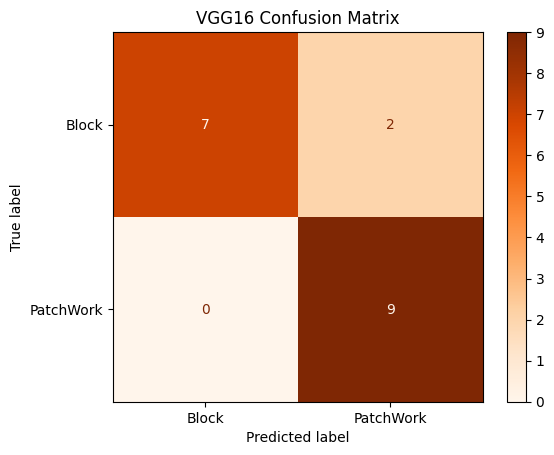

In [12]:
# --- Confusion Matrix ---
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Oranges)
plt.title("VGG16 Confusion Matrix")
plt.savefig("vgg16_confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
model.save('VGG-16_BC_model.h5')  # Save the trained model